In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
LR = pd.read_csv("/content/drive/MyDrive/mydataset/LR.csv")
LR.head(5)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
LR.fillna(LR.mean(), inplace=True)

In [4]:
x = LR.drop("TenYearCHD", axis = 1)
y = LR["TenYearCHD"]

In [6]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(x_scaled, y):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [17]:
print("class distribution before smooth:")
print(y_train.value_counts(normalize = True))

class distribution before smooth:
TenYearCHD
0    0.848083
1    0.151917
Name: proportion, dtype: float64


In [10]:
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

In [18]:
print("class distribution after smote")
print(y_train_balanced.value_counts(normalize = True))

class distribution after smote
TenYearCHD
0    0.5
1    0.5
Name: proportion, dtype: float64


In [19]:
param_grid = {
    'solver': ['sag', 'lbfgs', 'liblinear'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000], 'penalty': ['l2'],
                         'solver': ['sag', 'lbfgs', 'liblinear']},
             scoring='f1_weighted')

In [20]:
besr_logistic_model = grid_search.best_estimator_
print("\nBest Parameters for Logistic Regression:", grid_search.best_params_)


Best Parameters for Logistic Regression: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


In [30]:
y_pred_logistic = besr_logistic_model.predict(x_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic, target_names=['No CHD', 'CHD']))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      No CHD       0.90      0.66      0.76       719
         CHD       0.24      0.60      0.34       129

    accuracy                           0.65       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.80      0.65      0.70       848

Logistic Regression Confusion Matrix:
[[475 244]
 [ 52  77]]


In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [23]:
y_pred_rf = rf_model.predict(x_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No CHD', 'CHD']))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

      No CHD       0.86      0.91      0.88       719
         CHD       0.22      0.15      0.18       129

    accuracy                           0.79       848
   macro avg       0.54      0.53      0.53       848
weighted avg       0.76      0.79      0.77       848

Random Forest Confusion Matrix:
[[653  66]
 [110  19]]


In [24]:
y_pred_prob_logistic = besr_logistic_model.predict_proba(x_test)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

In [27]:
y_pred_prob_rf = rf_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

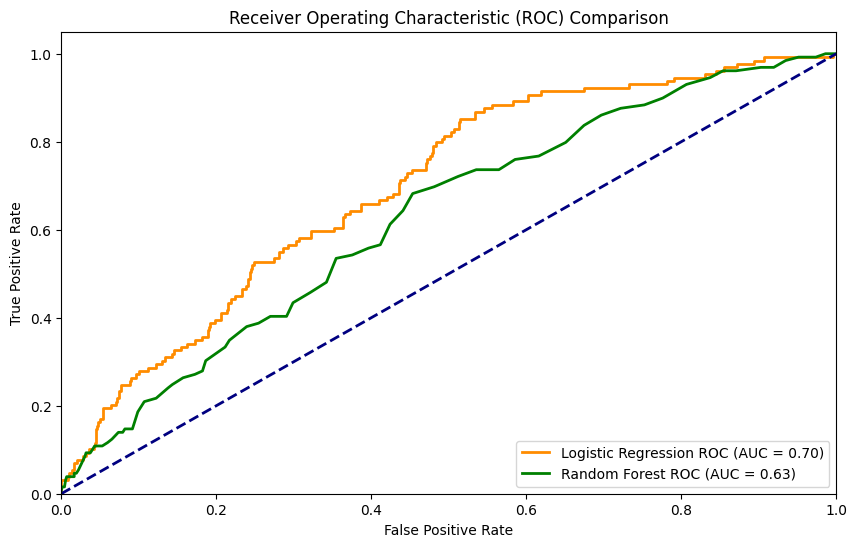

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2,
         label=f'Logistic Regression ROC (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2,
         label=f'Random Forest ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.show()